Firstly, just my usual, very basic function to import the datasets and get some information about them.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import cross_validate, GridSearchCV

def load_datasets(paths, info=True):
    def load(path, info):
        if len(path.split(".csv")) > 1:
            read = pd.read_csv(path)
        elif len(path.split(".xlsx")) > 1:
            read = pd.read_excel(path)

        if info:
            if len(read) > 0:
                print("# Data imported!")
                print("# ------------------------------------", "\n")

                print("# DIMENSIONS -------------------------")
                print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")

                print("# DTYPES -----------------------------")
                if len(read.select_dtypes("object").columns) > 0:
                    print("Object Variables:", "\n", "# of Variables:",
                          len(read.select_dtypes("object").columns), "\n",
                          read.select_dtypes("object").columns.tolist(), "\n")

                if len(read.select_dtypes("integer").columns) > 0:
                    print("Integer Variables:", "\n", "# of Variables:",
                          len(read.select_dtypes("integer").columns), "\n",
                          read.select_dtypes("integer").columns.tolist(), "\n")

                if len(read.select_dtypes("float").columns) > 0:
                    print("Float Variables:", "\n", "# of Variables:",
                          len(read.select_dtypes("float").columns), "\n",
                          read.select_dtypes("float").columns.tolist(), "\n")

                if len(read.select_dtypes("bool").columns) > 0:
                    print("Bool Variables:", "\n", "# of Variables:",
                          len(read.select_dtypes("bool").columns), "\n",
                          read.select_dtypes("bool").columns.tolist(), "\n")

                print("# MISSING VALUE ---------------------")
                print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False,
                                                                    "No missing value!", "Data includes missing value!"), "\n")

                buf = io.StringIO()
                read.info(buf=buf)
                info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
                print("# MEMORY USAGE ---------------------- \n", info)

            else:
                print("# Data did not import!")

        return read

    datasets = {}
    for key, path in paths.items():
        datasets[key] = load(path, info)
        info = False  # Only show detailed info for the first dataset

    return datasets

# Defining paths for the datasets
paths = {
    'movies': "C:/Users/Admin/Documents/SQL_PYTHON/recommendations/movies.csv",
    'ratings': "C:/Users/Admin/Documents/SQL_PYTHON/recommendations/ratings.csv"
}

# Loading the datasets
datasets = load_datasets(paths, info=True)

# Accessing the datasets
movies_df = datasets['movies']
ratings_df = datasets['ratings']

# Display and check the first few rows of the dataset
print(movies_df.head())
print(ratings_df.head())


Then we check again for missing values as well as removing any duplicates, in our case we do not have any

In [58]:

# Checking for missing values in both datasets
print(movies_df.isnull().sum())
print(ratings_df.isnull().sum())

# Droping duplicates if exists
movies_df.drop_duplicates(inplace=True)
ratings_df.drop_duplicates(inplace=True)

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Basic explanatory data analysis, to see the distribution of movie ratings as well as number of ratings per movie

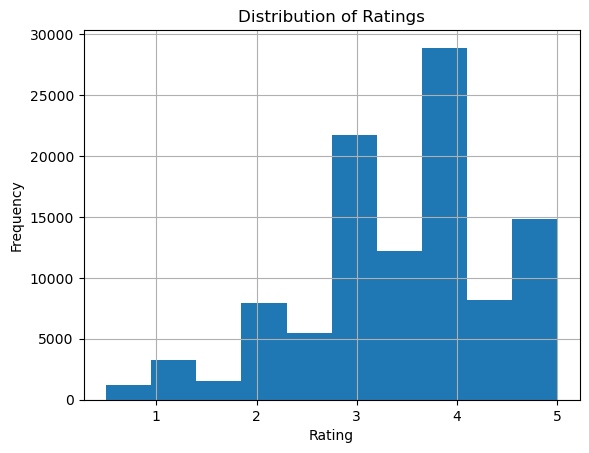

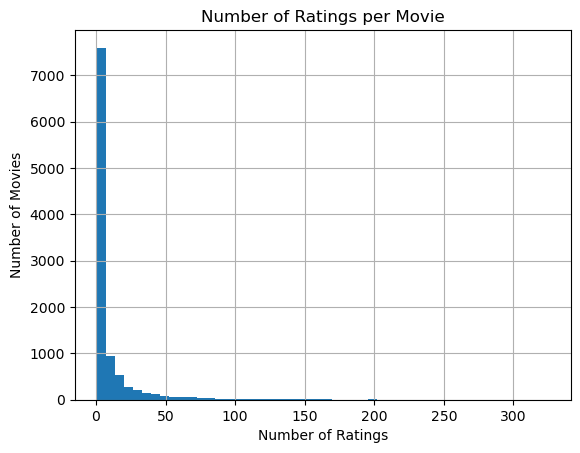

In [57]:
# EDA
# Distribution of movie ratings
ratings_df['rating'].hist(bins=10)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

# Number of ratings per movie
ratings_per_movie = ratings_df.groupby('movieId').size()
ratings_per_movie.hist(bins=50)
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Number of Ratings per Movie')
plt.show()

Now we are getting close to the fun part, firstly we merge the datasets on movieID. Then we are creating user-item matrix. In this case id does not tell us a lot as not every user votes for each of the movies. Then we visualize sparsity, which shows that the data is very sparse, meaning that only a small fraction of the matrix is filled with actual ratings (non-NaN values). This is a common characteristic in collaborative filtering datasets, where users typically rate only a few items out of the total available.

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              0.0                                      0.0   
2              0.0                                      0.0   
3              0.0                                      0.0   
4              0.0                                      0.0   
5              0.0                                      0.0   

title   'Round Midnight (1986)  'Til There Was You (1997)  'burbs, The (1989)  \
userId                                                                          
1                          0.0                        0.0                 0.0   
2                          0.0                        0.0                 0.0   
3                          0.0                        0.0                 0.0   
4                          0.0                        0.0                 0.0   
5                          0.0                        0.0               

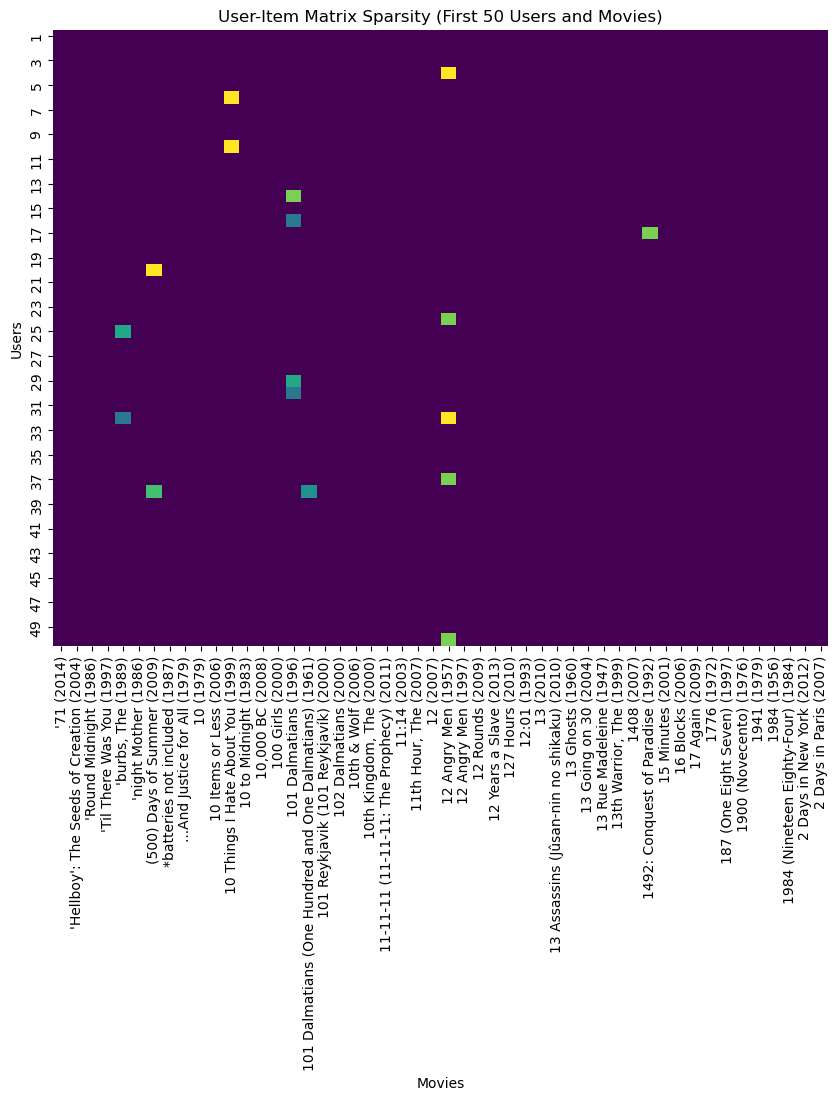

In [59]:
# Merge the datasets on 'movieId'
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

# Create the user-item matrix
user_item_matrix = merged_df.pivot_table(index='userId', columns='title', values='rating')

# Fill NaN values with 0 for visualization (do not use this filled matrix for training)
user_item_matrix_filled = user_item_matrix.fillna(0)

# Display the filled user-item matrix
print(user_item_matrix_filled.head())

# Visualize sparsity
plt.figure(figsize=(10, 8))
sns.heatmap(user_item_matrix_filled.iloc[:50, :50], cmap='viridis', cbar=False)
plt.xlabel('Movies')
plt.ylabel('Users')
plt.title('User-Item Matrix Sparsity (First 50 Users and Movies)')
plt.show()

And now to the good stuff. Firstly, we prepare the data for the Surprise lib. We use the Surprise lib. for building and evaluating different recommendation models. The models we compare include SVD (Singular Value Decomposition), KNNBasic, KNNWithMeans, KNNWithZScore, and KNNBaseline. Summarized results:
SVD: RMSE: 0.8710, MAE: 0.6715
KNNBasic: RMSE: 0.9566, MAE: 0.7369
KNNWithMeans: RMSE: 0.8958, MAE: 0.6867
KNNWithZScore: RMSE: 0.8933, MAE: 0.6806
KNNBaseline: RMSE: 0.8726, MAE: 0.6693

We want Root mean square error (RMSE) and Mean absolute error (MAE) to be the lowest value possible thus, it comes down to SVD and KNNBaseline. And while KNNBaseline has better MAE, we focus on RMSE in this case. Mainly because we have a very fixed interval of ratings thus, outliers is not really the case.

In [60]:
# Prepare the data for the Surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Define models to compare
models = [SVD(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline()]
model_names = ['SVD', 'KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'KNNBaseline']

# Initialize variables to track the best model
best_rmse = float('inf')
best_model = None

# Compare models
for model, name in zip(models, model_names):
    cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    mean_rmse = cv_results['test_rmse'].mean()
    mean_mae = cv_results['test_mae'].mean()
    print(f"{name} - RMSE: {mean_rmse} MAE: {mean_mae}")
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_model = model

print(f"Best model: {best_model.__class__.__name__} with RMSE: {best_rmse}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8735  0.8767  0.8681  0.8725  0.8644  0.8710  0.0043  
MAE (testset)     0.6715  0.6767  0.6702  0.6728  0.6661  0.6715  0.0034  
Fit time          0.71    0.83    0.79    0.89    0.77    0.80    0.06    
Test time         0.10    0.09    0.30    0.12    0.10    0.14    0.08    
SVD - RMSE: 0.8710253774935429 MAE: 0.6714538309036835
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)   

We aim to further improve our recommendation model by tuning its hyperparameters to be as efficient and as optimal as possible. My computer is slow that is the reason I used cv3 instead of 5. We get our optimal parameters so we could fine tune the model to achieve better accuracy by minimizing RMSE.

In [61]:
# Define the parameter grid for the best model
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# Best score and parameters from grid search
print("Best RMSE score from grid search:", gs.best_score['rmse'])
print("Best parameters from grid search:", gs.best_params['rmse'])

# Use the best model from grid search
best_model = gs.best_estimator['rmse']

Best RMSE score from grid search: 0.8563942510209367
Best parameters from grid search: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


Just training the best model on our entire dataset

In [62]:
# Train the best model on the full dataset
trainset = data.build_full_trainset()
best_model.fit(trainset)

And finally what we are all here waiting for. We generate top-N recommendations for each user using the best model identified. We get a top 10 movie recommendations on each different users. These recommendations are personalized, aiming to suggest movies that each user is likely to rate highly based on their past ratings.

In [63]:
def get_top_n_recommendations(model, n=10):
    top_n = {}
    for user_id in user_item_matrix.index:
        user_ratings = user_item_matrix.loc[user_id].dropna()
        rated_movie_titles = user_ratings.index.tolist()
        
        # Get movie IDs for the titles
        rated_movie_ids = movies_df[movies_df['title'].isin(rated_movie_titles)]['movieId'].tolist()
        
        # Get the list of all movie IDs
        all_movie_ids = movies_df['movieId'].tolist()
        
        # Filter out the movie IDs the user has already rated
        movie_ids_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movie_ids]
        
        # Predict ratings for the unrated movies
        predictions = [model.predict(user_id, movie_id) for movie_id in movie_ids_to_predict]
        
        # Sort predictions by estimated rating in descending order
        top_n[user_id] = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    return top_n

# Get top-10 recommendations for all users using the best model from GridSearchCV
top_n_recommendations = get_top_n_recommendations(best_model, 10)

# Print top recommendations for the first 10 users as an example
for user_id in list(top_n_recommendations.keys())[:10]:
    recommended_movies = [pred.iid for pred in top_n_recommendations[user_id]]
    recommended_titles = [movies_df[movies_df['movieId'] == movie_id]['title'].values[0] for movie_id in recommended_movies]
    print(f"Recommended movies for user {user_id}: {recommended_titles}")

Recommended movies for user 1: ['Fireworks (Hana-bi) (1997)', 'Cosmos (1980)', 'Louis C.K.: Shameless (2007)', 'Civil War, The (1990)', 'White Heat (1949)', 'Samouraï, Le (Godson, The) (1967)', 'The Big Short (2015)', 'Throne of Blood (Kumonosu jô) (1957)', 'Touch of Evil (1958)', 'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)']
Recommended movies for user 2: ['Never Let Me Go (2010)', 'Paths of Glory (1957)', 'Fireworks (Hana-bi) (1997)', 'Louis C.K.: Shameless (2007)', 'Nine Queens (Nueve reinas) (2000)', 'All Quiet on the Western Front (1930)', 'My Darling Clementine (1946)', '28 Up (1985)', 'White Heat (1949)', 'Lives of Others, The (Das leben der Anderen) (2006)']
Recommended movies for user 3: ['Fireworks (Hana-bi) (1997)', 'Black Mirror (2011)', 'Cosmos (1980)', 'Touch of Evil (1958)', 'Godfather, The (1972)', 'Nine Queens (Nueve reinas) (2000)', 'Great Expectations (1946)', 'Citizen Kane (1941)', 'White Heat (1949)', 'Song of the Little Road (Pather Panch

We also needed to solve the issue of new users, who do not have any rating history thus, we just recommend the most popular movies.

In [66]:
# Get the most popular movies
popular_movies = ratings_df.groupby('movieId').size().sort_values(ascending=False).head(10).index
popular_movie_titles = movies_df[movies_df['movieId'].isin(popular_movies)]['title']
print(f"Recommended movies for new users: {popular_movie_titles.tolist()}")


Recommended movies for new users: ['Braveheart (1995)', 'Star Wars: Episode IV - A New Hope (1977)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Jurassic Park (1993)', "Schindler's List (1993)", 'Terminator 2: Judgment Day (1991)', 'Silence of the Lambs, The (1991)', 'Matrix, The (1999)']


In [64]:
# Get users with the highest overall ratings
top_users = ratings_df.groupby('userId').mean()['rating'].sort_values(ascending=False).head(10).index
print(f"Recommended new items to top users: {top_users.tolist()}")


Recommended new items to top users: [78, 15, 550, 520, 144, 432, 604, 637, 119, 614]


And finally we visualize the distribution of ratings and the top-N movie recommendations for a specific user.

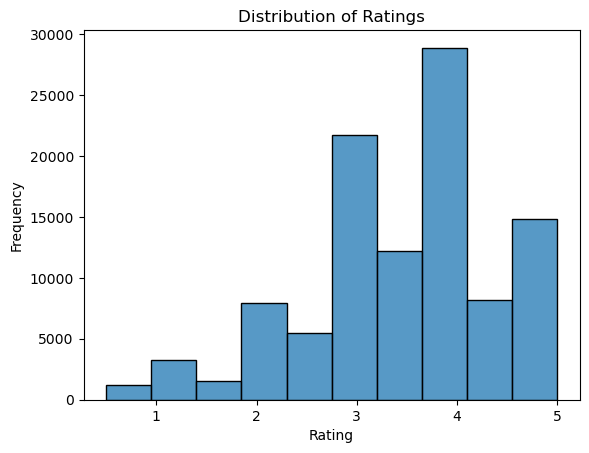

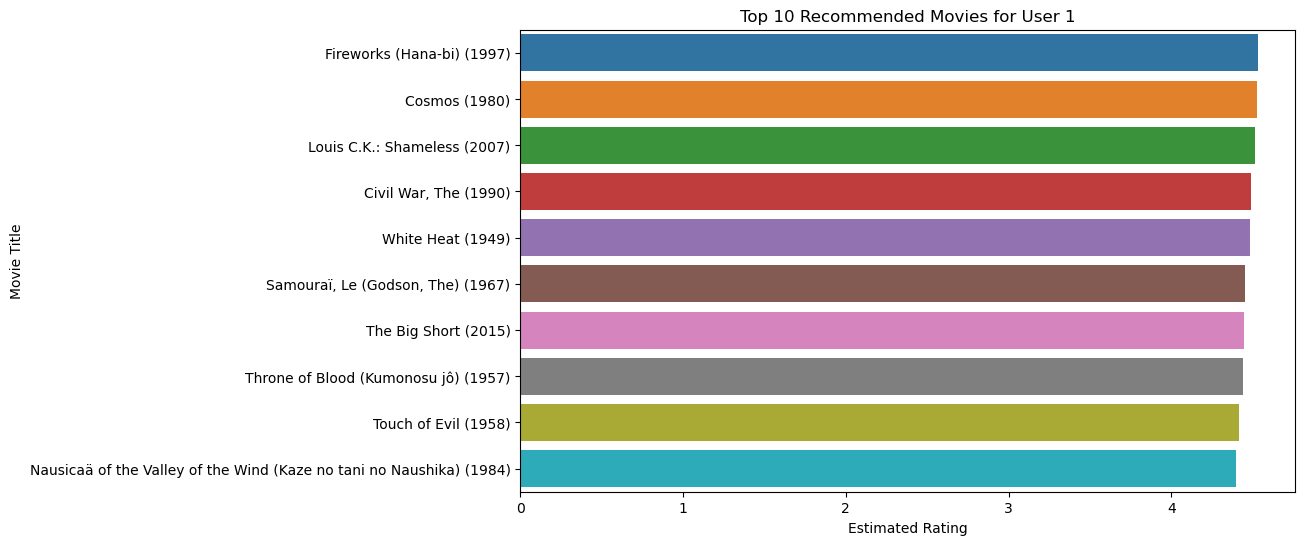

In [65]:


# Visualize the distribution of ratings
sns.histplot(ratings_df['rating'], bins=10, kde=False)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

# Visualize the top 10 recommended movies for a user
def plot_top_n_recommendations(user_id, top_n_recommendations):
    recommendations = top_n_recommendations[user_id]
    movie_titles = [movies_df[movies_df['movieId'] == pred.iid]['title'].values[0] for pred in recommendations]
    est_ratings = [pred.est for pred in recommendations]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=est_ratings, y=movie_titles)
    plt.xlabel('Estimated Rating')
    plt.ylabel('Movie Title')
    plt.title(f'Top {len(recommendations)} Recommended Movies for User {user_id}')
    plt.show()

# Plot top 10 recommendations for a specific user
plot_top_n_recommendations(user_id=1, top_n_recommendations=top_n_recommendations)
